In [2]:
### import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

# Models

## SEIR Model
A basic SEIR model was used to simulate the spread of an infectious disease in a population that was not vaccinated.

### Equations
$$\dot{S} = - \beta S I$$
$$\dot{E}= \beta S I - \sigma E$$
$$\dot{I} = \sigma E - \gamma I$$
$$\dot{R} = \gamma I$$

### Variables
- $S$: Susceptible population
- $E$: Exposed population
- $I$: Infected population
- $R$: Recovered population

### Parameters
- $\beta$: Rate at which infected individuals in class $I$ contact susceptible individuals and infect them
- $\sigma$: Rate at which susceptible individuals in class $S$ progress to the exposed population
- $\gamma$: Rate at which infected individuals in class $I$ recover from the disease and become immune

In [3]:
def seir (y, t, beta, sigma, gamma):    
    s, e, i, r = y
    dsdt = - beta*s*i
    dedt = beta*s*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i
    
    return dsdt, dedt, didt, drdt

## Modified SEIR Model
We modified the above SEIR model to investigate two possible vaccine failure mechanisms - 'leaky' and 'all-or-nothing'.

### Equations
$$\dot{S} = - \beta SI - (1 - \frac{V_{ES} + V_{RS}}{v})fS$$
$$\dot{V}_{ES} = (1 - \epsilon_A)(1 - \frac{V_{ES} + V_{RS}}{v})fS - \beta V_{ES}I$$
$$\dot{V}_{RS} = (1 - \frac{V_{ES} + V_{RS}}{v})fS\epsilon_A - (1-\epsilon_L)\beta V_{RS}I$$
$$\dot{E} = \beta SI + \beta V_{ES}I + (1 - \epsilon_L)\beta V_{RS}I - \sigma E$$
$$\dot{I} = \sigma E - \gamma I$$
$$\dot{R} = \gamma I$$

### Variables
- $S$: Susceptible and uninfected population
- $V_{ES}$: Vaccinated and uninfected population with equal susceptibility
- $V_{RS}$: Vaccinated and uninfected population with reduced susceptibility
- $E$: Exposed population
- $I$: Infected population
- $R$: Recovered population

### Parameters
- $\beta$: Rate at which infected individuals in class $I$ contact susceptible individuals and infect them
- $v$: Maximum fraction of population to be vaccinated
- $f(t)$: Vaccination rate at time t
- $\epsilon_A$: 'All-or-nothing' vaccine efficacy
- $\epsilon_L$: 'Leaky' vaccine efficacy
- $\sigma$: Rate at which susceptible individuals in class $S$ progress to the exposed population
- $\gamma$: Rate at which infected individuals in class $I$ recover from the disease and become immune

In [4]:
def modified_seir(y, t, beta, sigma, gamma, f, epsL, epsA, v):
    s, v_es, v_rs, e, i, r = y
    dsdt = - beta*s*i - f*(1-(v_es+v_rs)/v)*s
    dvesdt = f*(1-epsA)*(1-(v_es+v_rs)/v)*s - beta*v_es*i
    dvrsdt = f*epsA*(1-(v_es+v_rs)/v)*s - (1-epsL)*beta*v_rs*i
    dedt = beta*s*i + beta*v_es*i + (1-epsL)*beta*v_rs*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i
    return dsdt, dvesdt, dvrsdt, dedt, didt, drdt

## Basic Reproduction Number ($R_0$)

The basic reproduction number $R_0$ is defined as the average number of secondary cases produced by a single infected individual. This dimensionless number can be calculated by dividing the transmission rate of the disease by its recovery rate, as it represents the ratio of how fast the disease spreads to the expected duration of infection. 

$$ R_0 = \frac{\beta}{\gamma} $$

The $R_0$ value changes throughout the progression of the disease as interventions that lower the transmission rate are introduced, such as vaccination or quarantine. Note that the $R_0$ value used in these simulations is the value before any interventions are implemented. 


# Time-Series Plots

## Pre-transmission Vaccination
We will assume that vaccination happens all at once for simplicity. Note that for a leaky vaccine, $\epsilon_A = 1$, and for an all-or-nothing vaccine, $\epsilon_L = 1$.

For the plots below, $\beta, \gamma, \sigma$ values were chosen based on the characteristics of COVID-19, and $\epsilon_L, \epsilon_A, v$ were arbitrary values that show the difference between the two vaccine failure mechanisms.

In [28]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2*gamma; f = 0; vmax = 0.5
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; t = np.arange(0, 200)
s0_vax = 0.98-vmax; e0_vax = 0.01; i0_vax = 0.01

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
s, e, i, r = sim.T

# leaky
epsL = 0.5; epsA = 1; 
v_es0_leaky = 0; v_rs0_leaky = vmax; y0_vax_leaky = s0_vax, v_es0_leaky, v_rs0_leaky, e0_vax, i0_vax, r0
sim_leaky = odeint(modified_seir, y0_vax_leaky, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T
vtot_leaky = v_es_leaky + v_rs_leaky

# all-or-nothing
epsL = 1; epsA = 0.5; 
v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA; y0_vax_aon = s0_vax, v_es0_aon, v_rs0_aon, e0_vax, i0_vax, r0
sim_aon = odeint(modified_seir, y0_vax_aon, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T
vtot_aon = v_es_aon + v_rs_aon

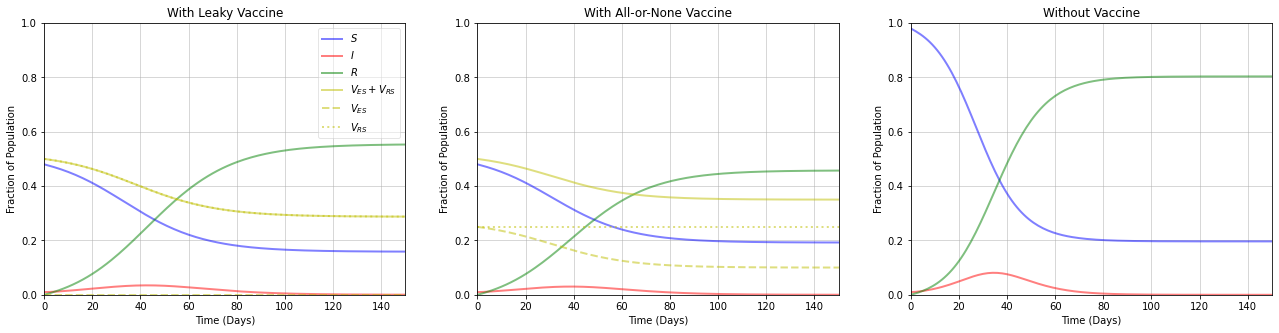

In [29]:
### plot figure
fig = plt.figure(facecolor='w', figsize=(22,5))

ax1 = fig.add_subplot(131, axisbelow=True)
ax1.plot(t, s_leaky, 'b', alpha=0.5, lw=2, label='$S$')
ax1.plot(t, i_leaky, 'r', alpha=0.5, lw=2, label='$I$')
ax1.plot(t, r_leaky, 'g', alpha=0.5, lw=2, label='$R$')
ax1.plot(t, vtot_leaky, 'y', alpha=0.5, lw=2, label='$V_{ES} + V_{RS}$')
ax1.plot(t, v_es_leaky, 'y--', alpha=0.5, lw=2, label='$V_{ES}$')
ax1.plot(t, v_rs_leaky, 'y:', alpha=0.5, lw=2, label='$V_{RS}$')
ax1.set_title("With Leaky Vaccine")
ax1.set_ylim(0, 1); ax1.set_xlim(0, 150)
ax1.set_ylabel("Fraction of Population")
ax1.set_xlabel('Time (Days)')
ax1.grid(linewidth=0.5)
legend = ax1.legend(); legend.get_frame().set_alpha(0.5)

ax2 = fig.add_subplot(132, axisbelow=True)
ax2.plot(t, s_aon, 'b', alpha=0.5, lw=2)
ax2.plot(t, i_aon, 'r', alpha=0.5, lw=2)
ax2.plot(t, r_aon, 'g', alpha=0.5, lw=2)
ax2.plot(t, vtot_aon, 'y', alpha=0.5, lw=2)
ax2.plot(t, v_es_aon, 'y--', alpha=0.5, lw=2)
ax2.plot(t, v_rs_aon, 'y:', alpha=0.5, lw=2)
ax2.set_title("With All-or-None Vaccine")
ax2.set_ylim(0, 1); ax2.set_xlim(0, 150)
ax2.set_ylabel("Fraction of Population")
ax2.set_xlabel('Time (Days)')
ax2.grid(linewidth=0.5)

ax3 = fig.add_subplot(133, axisbelow=True)
ax3.plot(t, s, 'b', alpha=0.5, lw=2)
ax3.plot(t, i, 'r', alpha=0.5, lw=2)
ax3.plot(t, r, 'g', alpha=0.5, lw=2)
ax3.set_title('Without Vaccine')
ax3.set_ylabel('Fraction of Population')
ax3.set_xlabel('Time (Days)')
ax3.set_ylim(0, 1); ax3.set_xlim(0, 150)
ax3.grid(linewidth=0.5)

#plt.savefig('seir_example', bbox_inches='tight')

## 10 Days Post-transmission Vaccination

In [30]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2*gamma; f = 0; vmax = 0.5
s0 = 0.98; v_es0 = 0; v_rs0 = 0; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; 
D = 150; D_vax = 10; t = np.arange(0, D+1)

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
s, e, i, r = sim.T

# vaccination
t_bfvax = np.arange(0, D_vax+1); t_aftvax = np.arange(D_vax, D+1)
sim_vax = odeint(seir, y0, t_bfvax, args=(beta, sigma, gamma))
s0_vax, e0_vax, i0_vax, r0_vax = sim_vax.T

# leaky
epsL = 0.5; epsA = 1
v_es0_leaky = 0; v_rs0_leaky = vmax
y0_vax_leaky = s0_vax[-1] - vmax, v_es0_leaky, v_rs0_leaky, e0_vax[-1], i0_vax[-1], r0_vax[-1]
sim_leaky = odeint(modified_seir, y0_vax_leaky, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s1_leaky, v_es1_leaky, v_rs1_leaky, e1_leaky, i1_leaky, r1_leaky = sim_leaky.T
vtot1_leaky = v_es1_leaky + v_rs1_leaky

s_leaky = np.concatenate((s0_vax[:-1], s1_leaky), axis=None)
e_leaky = np.concatenate((e0_vax[:-1], e1_leaky), axis=None)
i_leaky = np.concatenate((i0_vax[:-1], i1_leaky), axis=None)
r_leaky = np.concatenate((r0_vax[:-1], r1_leaky), axis=None)
vtot_leaky = np.concatenate((np.zeros(D_vax), vtot1_leaky), axis=None)
v_es_leaky = np.concatenate((np.zeros(D_vax), v_es1_leaky), axis=None)
v_rs_leaky = np.concatenate((np.zeros(D_vax), v_rs1_leaky), axis=None)

# aon
epsL = 1; epsA = 0.5
v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
y0_vax_aon = s0_vax[-1] - vmax, v_es0_aon, v_rs0_aon, e0_vax[-1], i0_vax[-1], r0_vax[-1]
sim_aon = odeint(modified_seir, y0_vax_aon, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s1_aon, v_es1_aon, v_rs1_aon, e1_aon, i1_aon, r1_aon = sim_aon.T
vtot1_aon = v_es1_aon + v_rs1_aon

s_aon = np.concatenate((s0_vax[:-1], s1_aon), axis=None)
e_aon = np.concatenate((e0_vax[:-1], e1_aon), axis=None)
i_aon = np.concatenate((i0_vax[:-1], i1_aon), axis=None)
r_aon = np.concatenate((r0_vax[:-1], r1_aon), axis=None)
vtot_aon = np.concatenate((np.zeros(D_vax), vtot1_aon), axis=None)
v_es_aon = np.concatenate((np.zeros(D_vax), v_es1_aon), axis=None)
v_rs_aon = np.concatenate((np.zeros(D_vax), v_rs1_aon), axis=None)

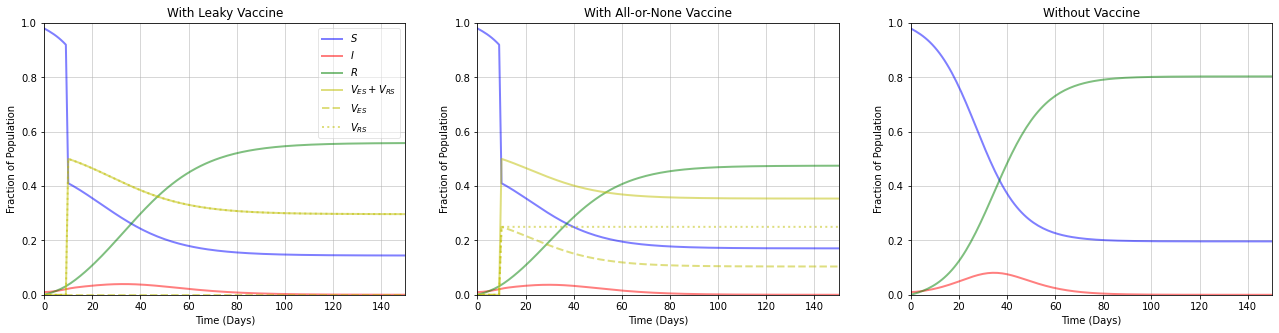

In [31]:
### plot figure
fig = plt.figure(facecolor='w', figsize=(22,5))

ax1 = fig.add_subplot(131, axisbelow=True)
ax1.plot(t, s_leaky, 'b', alpha=0.5, lw=2, label='$S$')
ax1.plot(t, i_leaky, 'r', alpha=0.5, lw=2, label='$I$')
ax1.plot(t, r_leaky, 'g', alpha=0.5, lw=2, label='$R$')
ax1.plot(t, vtot_leaky, 'y', alpha=0.5, lw=2, label='$V_{ES} + V_{RS}$')
ax1.plot(t, v_es_leaky, 'y--', alpha=0.5, lw=2, label='$V_{ES}$')
ax1.plot(t, v_rs_leaky, 'y:', alpha=0.5, lw=2, label='$V_{RS}$')
ax1.set_title("With Leaky Vaccine")
ax1.set_ylim(0, 1); ax1.set_xlim(0, 150)
ax1.set_ylabel("Fraction of Population")
ax1.set_xlabel('Time (Days)')
ax1.grid(linewidth=0.5)
legend = ax1.legend(); legend.get_frame().set_alpha(0.5)

ax2 = fig.add_subplot(132, axisbelow=True)
ax2.plot(t, s_aon, 'b', alpha=0.5, lw=2)
ax2.plot(t, i_aon, 'r', alpha=0.5, lw=2)
ax2.plot(t, r_aon, 'g', alpha=0.5, lw=2)
ax2.plot(t, vtot_aon, 'y', alpha=0.5, lw=2)
ax2.plot(t, v_es_aon, 'y--', alpha=0.5, lw=2)
ax2.plot(t, v_rs_aon, 'y:', alpha=0.5, lw=2)
ax2.set_title("With All-or-None Vaccine")
ax2.set_ylim(0, 1); ax2.set_xlim(0, 150)
ax2.set_ylabel("Fraction of Population")
ax2.set_xlabel('Time (Days)')
ax2.grid(linewidth=0.5)

ax3 = fig.add_subplot(133, axisbelow=True)
ax3.plot(t, s, 'b', alpha=0.5, lw=2)
ax3.plot(t, i, 'r', alpha=0.5, lw=2)
ax3.plot(t, r, 'g', alpha=0.5, lw=2)
ax3.set_title('Without Vaccine')
ax3.set_ylabel('Fraction of Population')
ax3.set_xlabel('Time (Days)')
ax3.set_ylim(0, 1); ax3.set_xlim(0, 150)
ax3.grid(linewidth=0.5)

#plt.savefig('seir_example', bbox_inches='tight')

## 30 Days Post-Transmission Vaccination

In [32]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2*gamma; f = 0; vmax = 0.5
s0 = 0.98; v_es0 = 0; v_rs0 = 0; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; 
D = 200; D_vax = 30; t = np.arange(0, D+1)

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
s, e, i, r = sim.T

# vaccination
t_bfvax = np.arange(0, D_vax+1); t_aftvax = np.arange(D_vax, D+1)
sim_vax = odeint(seir, y0, t_bfvax, args=(beta, sigma, gamma))
s0_vax, e0_vax, i0_vax, r0_vax = sim_vax.T

# leaky
epsL = 0.5; epsA = 1
v_es0_leaky = 0; v_rs0_leaky = vmax
y0_vax_leaky = s0_vax[-1] - vmax, v_es0_leaky, v_rs0_leaky, e0_vax[-1], i0_vax[-1], r0_vax[-1]
sim_leaky = odeint(modified_seir, y0_vax_leaky, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s1_leaky, v_es1_leaky, v_rs1_leaky, e1_leaky, i1_leaky, r1_leaky = sim_leaky.T
vtot1_leaky = v_es1_leaky + v_rs1_leaky

s_leaky = np.concatenate((s0_vax[:-1], s1_leaky), axis=None)
e_leaky = np.concatenate((e0_vax[:-1], e1_leaky), axis=None)
i_leaky = np.concatenate((i0_vax[:-1], i1_leaky), axis=None)
r_leaky = np.concatenate((r0_vax[:-1], r1_leaky), axis=None)
vtot_leaky = np.concatenate((np.zeros(D_vax), vtot1_leaky), axis=None)
v_es_leaky = np.concatenate((np.zeros(D_vax), v_es1_leaky), axis=None)
v_rs_leaky = np.concatenate((np.zeros(D_vax), v_rs1_leaky), axis=None)

# aon
epsL = 1; epsA = 0.5
v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
y0_vax_aon = s0_vax[-1] - vmax, v_es0_aon, v_rs0_aon, e0_vax[-1], i0_vax[-1], r0_vax[-1]
sim_aon = odeint(modified_seir, y0_vax_aon, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s1_aon, v_es1_aon, v_rs1_aon, e1_aon, i1_aon, r1_aon = sim_aon.T
vtot1_aon = v_es1_aon + v_rs1_aon

s_aon = np.concatenate((s0_vax[:-1], s1_aon), axis=None)
e_aon = np.concatenate((e0_vax[:-1], e1_aon), axis=None)
i_aon = np.concatenate((i0_vax[:-1], i1_aon), axis=None)
r_aon = np.concatenate((r0_vax[:-1], r1_aon), axis=None)
vtot_aon = np.concatenate((np.zeros(D_vax), vtot1_aon), axis=None)
v_es_aon = np.concatenate((np.zeros(D_vax), v_es1_aon), axis=None)
v_rs_aon = np.concatenate((np.zeros(D_vax), v_rs1_aon), axis=None)

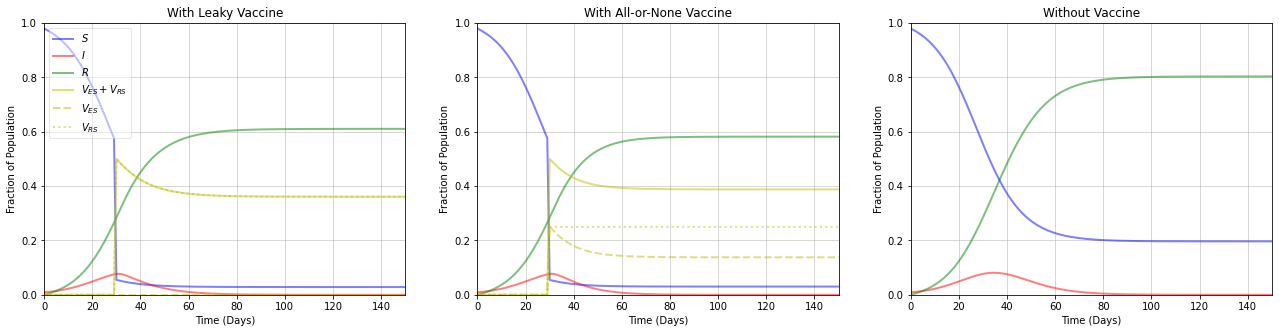

In [33]:
### plot figure
fig = plt.figure(facecolor='w', figsize=(22,5))

ax1 = fig.add_subplot(131, axisbelow=True)
ax1.plot(t, s_leaky, 'b', alpha=0.5, lw=2, label='$S$')
ax1.plot(t, i_leaky, 'r', alpha=0.5, lw=2, label='$I$')
ax1.plot(t, r_leaky, 'g', alpha=0.5, lw=2, label='$R$')
ax1.plot(t, vtot_leaky, 'y', alpha=0.5, lw=2, label='$V_{ES} + V_{RS}$')
ax1.plot(t, v_es_leaky, 'y--', alpha=0.5, lw=2, label='$V_{ES}$')
ax1.plot(t, v_rs_leaky, 'y:', alpha=0.5, lw=2, label='$V_{RS}$')
ax1.set_title("With Leaky Vaccine")
ax1.set_ylim(0, 1); ax1.set_xlim(0, 150)
ax1.set_ylabel("Fraction of Population")
ax1.set_xlabel('Time (Days)')
ax1.grid(linewidth=0.5)
legend = ax1.legend(); legend.get_frame().set_alpha(0.5)

ax2 = fig.add_subplot(132, axisbelow=True)
ax2.plot(t, s_aon, 'b', alpha=0.5, lw=2)
ax2.plot(t, i_aon, 'r', alpha=0.5, lw=2)
ax2.plot(t, r_aon, 'g', alpha=0.5, lw=2)
ax2.plot(t, vtot_aon, 'y', alpha=0.5, lw=2)
ax2.plot(t, v_es_aon, 'y--', alpha=0.5, lw=2)
ax2.plot(t, v_rs_aon, 'y:', alpha=0.5, lw=2)
ax2.set_title("With All-or-None Vaccine")
ax2.set_ylim(0, 1); ax2.set_xlim(0, 150)
ax2.set_ylabel("Fraction of Population")
ax2.set_xlabel('Time (Days)')
ax2.grid(linewidth=0.5)

ax3 = fig.add_subplot(133, axisbelow=True)
ax3.plot(t, s, 'b', alpha=0.5, lw=2)
ax3.plot(t, i, 'r', alpha=0.5, lw=2)
ax3.plot(t, r, 'g', alpha=0.5, lw=2)
ax3.set_title('Without Vaccine')
ax3.set_ylabel('Fraction of Population')
ax3.set_xlabel('Time (Days)')
ax3.set_ylim(0, 1); ax3.set_xlim(0, 150)
ax3.grid(linewidth=0.5)

#plt.savefig('seir_example', bbox_inches='tight')

# Exploring Scenarios
In order to explore regimes in which the two different vaccine failure mechanisms result in a significant difference, we quantified the impact of vaccine failure using the total recovered population. For each of the three vaccination scenarios (pre-transmission, 10 days post-transmission, 30 days post-transmission), the $R_0$ values were varied from 1.0 to 3.0, vaccine efficacy was varied from 1% effective to 100% effective, and for each $R_0$ value and vaccine efficacy, we used three different vaccination population values - below, slightly above, and above the critical vaccination level. Note that the $R_0$ values used are the values before intervention.

## Critical Vaccination Level ($V_c$)
The critical vaccination level is the proportion of the population that must be vaccinated in order to reach herd immunity, preventing further transmission of the disease. This value depends on how fast the disease spreads and how effective the vaccine is, as more people would need to get vaccinated if the disease had a high $R_0$ value and low vaccine efficacy. Note that the critical vaccination level cannot exceed 1.

$$ \text{Critical Vaccination Level ($V_c$)} = \frac{(1 - \frac{1}{R_0})}{\epsilon} $$

Furthermore, the three vaccinated population values were determined based on the above critical vaccination level as follows, ensuring the values are all between 0 and 1. 

$$ v_\text{below $V_c$} = V_c * 0.8$$
$$ v_\text{slightly above $V_c$} =  1 - ((1 - V_c) * 0.8) $$
$$ v_\text{above $V_c$} = 1 - ((1 - V_c) * 0.5) $$

We then calculated the percentage reduction of the total recovered population compared to that of without vaccination and plotted the difference in percentage reduction between the two vaccine failure mechanisms. The total recovered population was obtained by taking the last value of the $R$ class after running the simulation for 15,000 days.

Note that the other parameter values remain the same as the above time-series plots, and we also assume vaccination happens all at once.

## Pre-transmission Vaccination

In [46]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4; f = 0
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; 
D = 15000; t = np.arange(0, D+1)

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
hits = ['Below HIT', 'Slightly Above HIT', 'Above HIT']; df_vmaxs = []; df_hits = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    s, e, i, r = sim.T
    
    r_tot = r[-1]
            
    for eps in epss:
        hit_val = (1-1/R0)/eps
        for hit in hits:
            if hit == 'Below HIT':
                vmax = hit_val * 0.8
            elif hit == 'Slightly Above HIT':
                vmax = 1 - ((1 - hit_val) * 0.8)
            else:
                vmax = 1 - ((1 - hit_val) * 0.5)

            # leaky
            epsL = eps; epsA = 1
            s0_vax = 0.98-vmax; v_es0_leaky = 0; v_rs0_leaky = vmax
            y0_vax_leaky = s0_vax, v_es0_leaky, v_rs0_leaky, e0, i0, r0
            sim_leaky = odeint(modified_seir, y0_vax_leaky, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T

            r_tot_leaky = r_leaky[-1]
            r_perc_leaky = abs(r_tot - r_tot_leaky) / r_tot * 100

            # aon
            epsL = 1; epsA = eps
            s0_vax = 0.98-vmax; v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
            y0_vax_aon = s0_vax, v_es0_aon, v_rs0_aon, e0, i0, r0
            sim_aon = odeint(modified_seir, y0_vax_aon, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T

            r_tot_aon = r_aon[-1]
            r_perc_aon = abs(r_tot - r_tot_aon) / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky
            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_vmaxs.append(vmax)
            df_hits.append(hit)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)

# build dataframe                        
df_timings = ['Pre' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Population': df_hits, 'vmax': df_vmaxs, 'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
pre_df = pd.DataFrame(data=data)

below_pre_df = pre_df[pre_df['Vax Population'] == 'Below HIT']
slabove_pre_df = pre_df[pre_df['Vax Population'] == 'Slightly Above HIT']
above_pre_df = pre_df[pre_df['Vax Population'] == 'Above HIT']

# reshape data for plotting
pre_plot_R0, pre_plot_VE = np.nan_to_num(np.meshgrid(R0s, epss, indexing='ij'))
pre_plot_diff_below = np.nan_to_num(np.reshape(below_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0)))
pre_plot_diff_slabove = np.nan_to_num(np.reshape(slabove_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0)))
pre_plot_diff_above = np.nan_to_num(np.reshape(above_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0)))

/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_92794/3220642344.py:3: RuntimeWarning: invalid value encountered in double_scalars
  dsdt = - beta*s*i - f*(1-(v_es+v_rs)/v)*s
/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_92794/3220642344.py:4: RuntimeWarning: invalid value encountered in double_scalars
  dvesdt = f*(1-epsA)*(1-(v_es+v_rs)/v)*s - beta*v_es*i
/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_92794/3220642344.py:5: RuntimeWarning: invalid value encountered in double_scalars
  dvrsdt = f*epsA*(1-(v_es+v_rs)/v)*s - (1-epsL)*beta*v_rs*i


## 10 Days Post-transmission Vaccination

In [47]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4; f = 0
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0
D = 15000; D_vax = 10; t = np.arange(0, D+1); 
t_bfvax = np.arange(0, D_vax+1); t_aftvax = np.arange(D_vax, D+1)

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
hits = ['Below HIT', 'Slightly Above HIT', 'Above HIT']; df_vmaxs = []; df_hits = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    s, e, i, r = sim.T
    
    r_tot = r[-1]
            
    sim_vax = odeint(seir, y0, t_bfvax, args=(beta, sigma, gamma))
    s0_vax, e0_vax, i0_vax, r0_vax = sim_vax.T

    for eps in epss:
        hit_val = (1-1/R0)/eps
        for hit in hits:
            if hit == 'Below HIT':
                vmax = hit_val * 0.8
            elif hit == 'Slightly Above HIT':
                vmax = 1 - ((1 - hit_val) * 0.8)
            else:
                vmax = 1 - ((1 - hit_val) * 0.5)

            # leaky
            epsL = eps; epsA = 1
            v_es0_leaky = 0; v_rs0_leaky = vmax
            y0_vax_leaky = s0_vax[-1] - vmax, v_es0_leaky, v_rs0_leaky, e0_vax[-1], i0_vax[-1], r0_vax[-1]
            sim_leaky = odeint(modified_seir, y0_vax_leaky, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T

            r_tot_leaky = r_leaky[-1]
            r_perc_leaky = abs(r_tot - r_tot_leaky) / r_tot * 100

            # aon
            epsL = 1; epsA = eps
            v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
            y0_vax_aon = s0_vax[-1] - vmax, v_es0_aon, v_rs0_aon, e0_vax[-1], i0_vax[-1], r0_vax[-1]
            sim_aon = odeint(modified_seir, y0_vax_aon, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T

            r_tot_aon = r_aon[-1]
            r_perc_aon = abs(r_tot - r_tot_aon) / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky
            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_vmaxs.append(vmax)
            df_hits.append(hit)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)
                        
# build dataframe
df_timings = ['Post 10' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Population': df_hits, 'vmax': df_vmaxs, 'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
post10_df = pd.DataFrame(data=data)

below_post10_df = post10_df[post10_df['Vax Population'] == 'Below HIT']
slabove_post10_df = post10_df[post10_df['Vax Population'] == 'Slightly Above HIT']
above_post10_df = post10_df[post10_df['Vax Population'] == 'Above HIT']

# reshape data for plotting
post10_plot_R0, post10_plot_VE = np.nan_to_num(np.meshgrid(R0s, epss, indexing='ij'))
post10_plot_diff_below = np.nan_to_num(np.reshape(below_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0)))
post10_plot_diff_slabove = np.nan_to_num(np.reshape(slabove_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0)))
post10_plot_diff_above = np.nan_to_num(np.reshape(above_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0)))

/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_92794/3220642344.py:3: RuntimeWarning: invalid value encountered in double_scalars
  dsdt = - beta*s*i - f*(1-(v_es+v_rs)/v)*s
/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_92794/3220642344.py:4: RuntimeWarning: invalid value encountered in double_scalars
  dvesdt = f*(1-epsA)*(1-(v_es+v_rs)/v)*s - beta*v_es*i
/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_92794/3220642344.py:5: RuntimeWarning: invalid value encountered in double_scalars
  dvrsdt = f*epsA*(1-(v_es+v_rs)/v)*s - (1-epsL)*beta*v_rs*i


## 30 Days Post-transmission Vaccination

In [48]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4; f = 0
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0
D = 15000; D_vax = 30; t = np.arange(0, D+1); 
t_bfvax = np.arange(0, D_vax+1); t_aftvax = np.arange(D_vax, D+1)

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
hits = ['Below HIT', 'Slightly Above HIT', 'Above HIT']; df_vmaxs = []; df_hits = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    s, e, i, r = sim.T
    
    r_tot = r[-1]
            
    sim_vax = odeint(seir, y0, t_bfvax, args=(beta, sigma, gamma))
    s0_vax, e0_vax, i0_vax, r0_vax = sim_vax.T

    for eps in epss:
        hit_val = (1-1/R0)/eps
        for hit in hits:
            if hit == 'Below HIT':
                vmax = hit_val * 0.8
            elif hit == 'Slightly Above HIT':
                vmax = 1 - ((1 - hit_val) * 0.8)
            else:
                vmax = 1 - ((1 - hit_val) * 0.5)

            # leaky
            epsL = eps; epsA = 1
            v_es0_leaky = 0; v_rs0_leaky = vmax
            y0_vax_leaky = s0_vax[-1] - vmax, v_es0_leaky, v_rs0_leaky, e0_vax[-1], i0_vax[-1], r0_vax[-1]
            sim_leaky = odeint(modified_seir, y0_vax_leaky, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T

            r_tot_leaky = r_leaky[-1]
            r_perc_leaky = abs(r_tot - r_tot_leaky) / r_tot * 100

            # aon
            epsL = 1; epsA = eps
            v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
            y0_vax_aon = s0_vax[-1] - vmax, v_es0_aon, v_rs0_aon, e0_vax[-1], i0_vax[-1], r0_vax[-1]
            sim_aon = odeint(modified_seir, y0_vax_aon, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T

            r_tot_aon = r_aon[-1]
            r_perc_aon = abs(r_tot - r_tot_aon) / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky
            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_vmaxs.append(vmax)
            df_hits.append(hit)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)

# build data frame                      
df_timings = ['Post 30' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Population': df_hits, 'vmax': df_vmaxs, 'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
post30_df = pd.DataFrame(data=data)

below_post30_df = post30_df[post30_df['Vax Population'] == 'Below HIT']
slabove_post30_df = post30_df[post30_df['Vax Population'] == 'Slightly Above HIT']
above_post30_df = post30_df[post30_df['Vax Population'] == 'Above HIT']

# reshape data for plotting
post30_plot_R0, post30_plot_VE = np.nan_to_num(np.meshgrid(R0s, epss, indexing='ij'))
post30_plot_diff_below = np.nan_to_num(np.reshape(below_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0)))
post30_plot_diff_slabove = np.nan_to_num(np.reshape(slabove_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0)))
post30_plot_diff_above = np.nan_to_num(np.reshape(above_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0)))

/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_92794/3220642344.py:3: RuntimeWarning: invalid value encountered in double_scalars
  dsdt = - beta*s*i - f*(1-(v_es+v_rs)/v)*s
/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_92794/3220642344.py:4: RuntimeWarning: invalid value encountered in double_scalars
  dvesdt = f*(1-epsA)*(1-(v_es+v_rs)/v)*s - beta*v_es*i
/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_92794/3220642344.py:5: RuntimeWarning: invalid value encountered in double_scalars
  dvrsdt = f*epsA*(1-(v_es+v_rs)/v)*s - (1-epsL)*beta*v_rs*i


## Results

Based on the values obtained from above, we plotted the absolute value of the difference between the two vaccine failure mechanisms in the percentage reduction of the total recovered population. Note that the values were plotted based on a log-scale, but the colorbar on the right of each plot is labelled based on the actual values. 

### 3D Surface Plot

/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_92794/3677349114.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(np.linspace(0.0, 4.0, 9))))


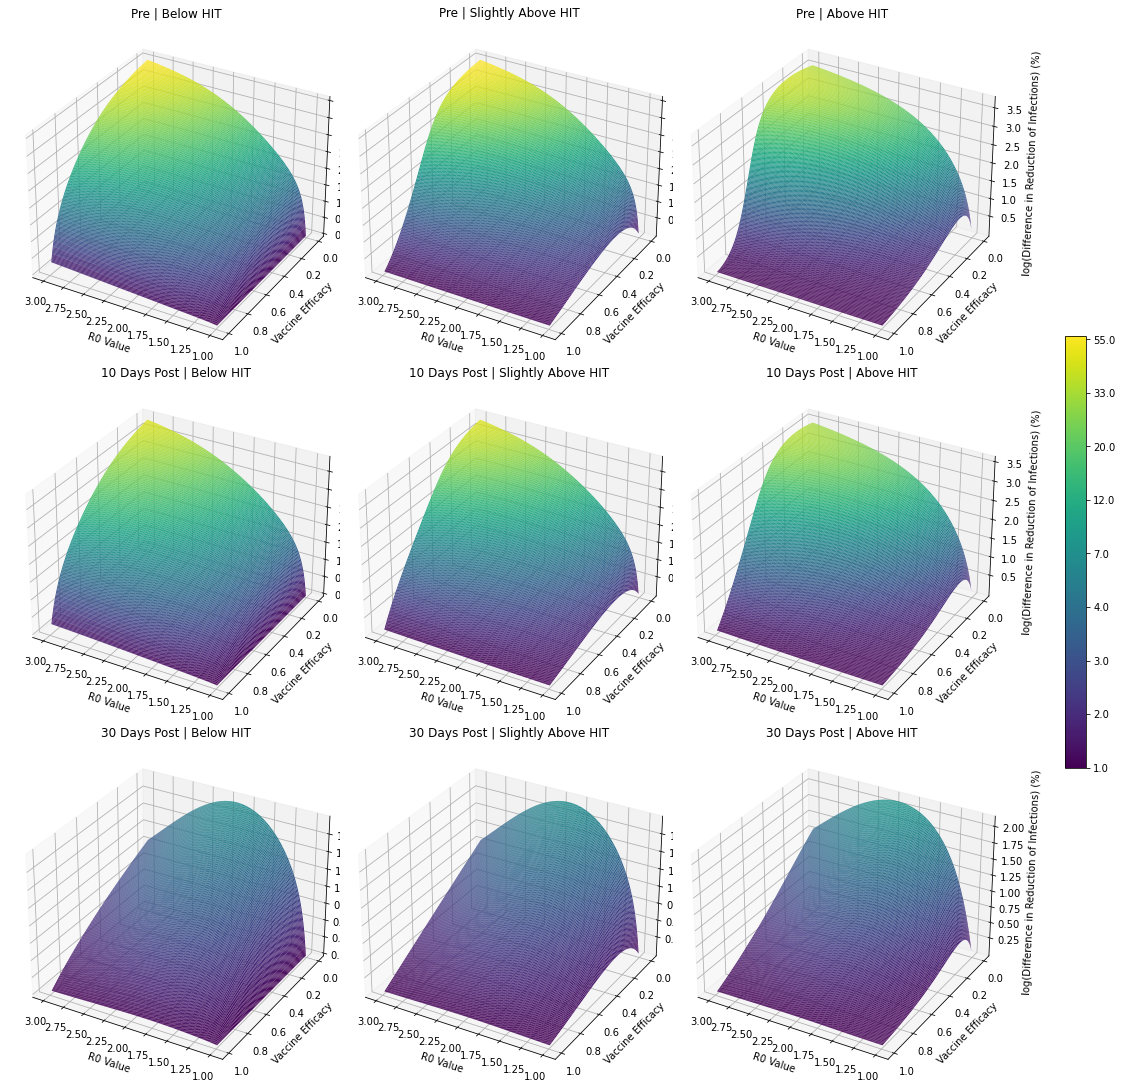

In [51]:
fig, axes = plt.subplots(3,3, facecolor='w', figsize=(15,15), gridspec_kw=dict(width_ratios=[1,1,1]), subplot_kw={'projection': '3d'})
norm = plt.Normalize(np.min(np.log(pre_plot_diff_below+1)), np.max(np.log(pre_plot_diff_below+1)))

# Pre-transmission
surf1 = axes[0,0].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_below+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[0,0].set_title('Pre | Below HIT')

axes[0,1].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_slabove+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[0,1].set_title('Pre | Slightly Above HIT')

axes[0,2].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_above+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[0,2].set_title('Pre | Above HIT')
axes[0,2].set_zlabel('log(Difference in Reduction of Infections) (%)')


# 10 days post-tranmission
axes[1,0].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_below+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[1,0].set_title('10 Days Post | Below HIT')

axes[1,1].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_slabove+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[1,1].set_title('10 Days Post | Slightly Above HIT')

axes[1,2].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_above+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[1,2].set_title('10 Days Post | Above HIT')
axes[1,2].set_zlabel('log(Difference in Reduction of Infections) (%)')

# 30 days post-transmission
axes[2,0].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_below+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[2,0].set_title('30 Days Post | Below HIT')

axes[2,1].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_slabove+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[2,1].set_title('30 Days Post | Slightly Above HIT')

axes[2,2].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_above+1), rstride=1, cstride=1, norm=norm, cmap='viridis')
axes[2,2].set_title('30 Days Post | Above HIT')
axes[2,2].set_zlabel('log(Difference in Reduction of Infections) (%)')

axs = np.array(axes)
for ax in axs.reshape(-1):
    ax.set_xlabel('R0 Value')
    ax.set_ylabel('Vaccine Efficacy')
    ax.view_init(elev=30, azim=120)


fig.tight_layout(pad=0.05)
cb = fig.colorbar(mappable=surf1, ax=axes, fraction=0.02, shrink=0.5)
cb.ax.set_yticklabels(np.round(np.exp(np.linspace(0.0, 4.0, 9))))
#plt.savefig('VE vs R0 Surface Plot', bbox_inches='tight')
plt.show()

### 2D Contour Plot

This plot is the 2D projection of the 3D surface plot above.

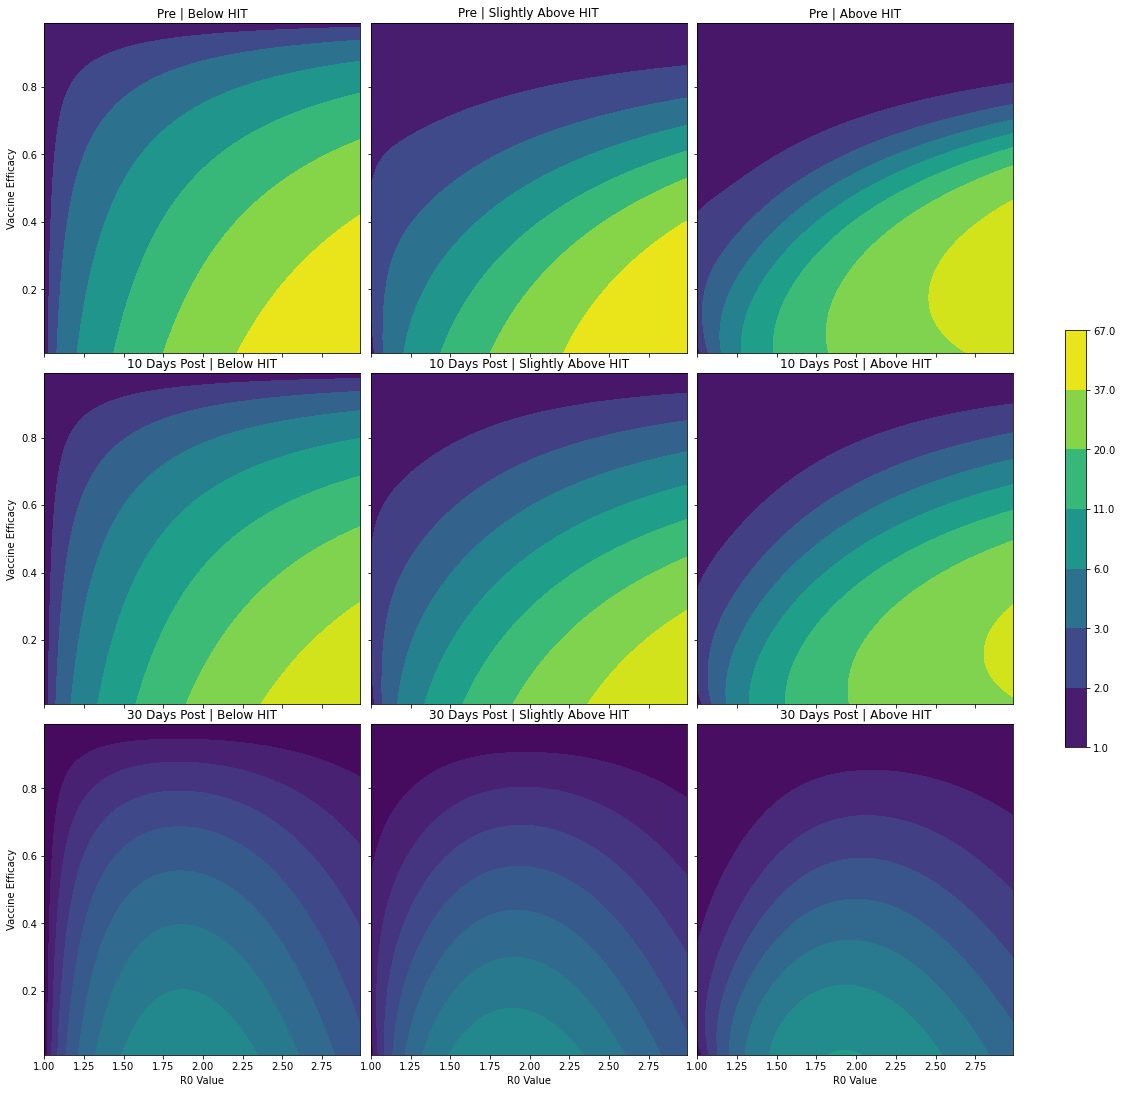

In [55]:
fig, axes = plt.subplots(3,3, facecolor='w', figsize=(15,15), sharex=True, sharey=True, gridspec_kw=dict(width_ratios=[1,1,1]))
norm = plt.Normalize(np.min(np.log(pre_plot_diff_below+1)), np.max(np.log(pre_plot_diff_below+1)))

# Pre-transmission 
proj = axes[0,0].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_below+1), norm=norm, cmap='viridis')
axes[0,0].set_title('Pre | Below HIT')
axes[0,0].set_ylabel('Vaccine Efficacy')

axes[0,1].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_slabove+1), norm=norm, cmap='viridis')
axes[0,1].set_title('Pre | Slightly Above HIT')

#ax3 = fig.add_subplot(133)
axes[0,2].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_above+1), norm=norm, cmap='viridis')
axes[0,2].set_title('Pre | Above HIT')

# 10 days post-transmission
axes[1,0].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_below+1), norm=norm, cmap='viridis')
axes[1,0].set_title('10 Days Post | Below HIT')
axes[1,0].set_ylabel('Vaccine Efficacy')

axes[1,1].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_slabove+1), norm=norm, cmap='viridis')
axes[1,1].set_title('10 Days Post | Slightly Above HIT')

axes[1,2].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_above+1), norm=norm, cmap='viridis')
axes[1,2].set_title('10 Days Post | Above HIT')

# 30 days post-transmission
axes[2,0].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_below+1), norm=norm, cmap='viridis')
axes[2,0].set_title('30 Days Post | Below HIT')
axes[2,0].set_ylabel('Vaccine Efficacy')
axes[2,0].set_xlabel('R0 Value')

axes[2,1].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_slabove+1), norm=norm, cmap='viridis')
axes[2,1].set_title('30 Days Post | Slightly Above HIT')
axes[2,1].set_xlabel('R0 Value')

axes[2,2].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_above+1), norm=norm, cmap='viridis')
axes[2,2].set_title('30 Days Post | Above HIT')
axes[2,2].set_xlabel('R0 Value')

fig.tight_layout(pad=0.05)
cb = fig.colorbar(mappable=proj, ax=axes, fraction=0.02, shrink=0.5)
cb.ax.set_yticklabels(np.round(np.exp(np.linspace(0.0, 4.2, 8))))
#plt.savefig('VE vs R0 2D Contour Plot', bbox_inches='tight')
plt.show()